## Group number: 26. 
### Group members: Ara Kwon, Anastasija Lagodzinska, Nihat Mansurov, Taewoo Kim

# Title: Relationship Between Player Experience and Hours Played

# 1. Introduction

## Background information

Data collection and analysis is an important and valuable tool for game development and improvement. Player characteristics analysis and its influence on player's behavior helps to identify patterns and create strategies for increasing game engagement and attracting more users. Since this report analyzes data from a game research project, using existing data for attracting new players can help to expand the project and strengthen the research.  
In this report we want to determine if there is a relationship between the total hours played by user and their experience level. We are interested whether we can predict the time our new user will spend playing the game knowing their experience level. This data will help us to determine which users are most active on the server and which playtime corresponds to each experience category. This requires regression analysis, as we want to predict numerical value (hours) based on a categorical value (experience level). In this case, we use KNN regression to analyze the values closest to the new observation, in order to make a prediction about the hours new players will spend on the server.  
This report shows how identifying patterns between previously known players characteristics can help researchers to predict players behavior in the future.

## Research question

**Broad question:** Which "kinds" of players are most likely to contribute a large amount of data?   
**Specific question:** Can `experience` predict `played_hours` in the `players` dataset?

## Dataset Description

### Dataset summary  
Data generated by research group in Computer Science at UBC, led by Frank Wood.  
Game research project goal is to enable advanced AI research by analyzing player's actions on a MineCraft(PLAICraft) server.
Data collected from the people who signed up and played on PLAICraft server. 
#### Players dataset summary    
Contains a list of all unique players and data about each player.   
**Number of observations**: 196   
**Number of variables**: 7  
**Summary statistics**:
|                            |Average    |Min    |Max|
|----------------------------|-----------|-------|-------|
|**Total time played (in hours)**|5.85       |0      |223.10|
|**User's age**                 |21         |9      |58|    

**Variables**:  
- `experience`(character) - User's experience level. Five categories: Pro(professional player), Veteran(plays for a long time), Amateur, Regular(frequent player) and Beginner.
- `subscribe`(logical) - User's subscription status to a game-related newsletter.
- `hashedEmail`(character) - Encoded user's email.
- `played_hours`(double) - Total hours played by user.
- `name`(character) - User's first name.
- `gender`(character) - User's gender. Seven categories: Male, Female, Non-binary, Prefer not to say, Agender, Two-Spirited, Other.
- `Age`(integer) - User's age.  
**Dataset issues**:
  - inconsistent column names
  - missing age values
  - factor values stored as charcters
  - played hours precision (stored as hours not minutes)  
### Sessions dataset summary
Contains a list of individual play sessions by each player and data about the session.  
**Number of observations**: 1535   
**Number of variables**: 5  
**Observation period**: 06/04/2024 - 26/09/2024   
**Variables**:  
- `hashedEmail`(character) - Encoded user's email.
- `start_time`(character) - Formatted date and time of the player`s game session start.
- `end_time`(character) - Formatted date and time of the player`s game session end.
- `original_start_time`(double) - Date and time of the player`s game session start stored as a number.
- `original_end_time`(double) - Date and time of the player`s game session end stored as a number.  
**Dataset issues**:
  - inconsistent column names
  - missing time values
  - start_time and end_time stored as character values, not in a dattime format

# 2. Methods & Results

In [1]:
# Adding all necessary libraries to the report
library(tidyverse)
library(lubridate)
library(dplyr)
library(cowplot)
library(RColorBrewer)
library(repr)
library(tidymodels)
source('cleanup.R')
# Setting tthe maximum rows displayed for a tibble
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ──────────────────────

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


## Loading Data

Loading players dataset:

In [2]:
url_players <- "https://raw.githubusercontent.com/ALagodzinska/Group26-FinalReport/refs/heads/main/data/players.csv"

players <- read_delim(url_players, delim = ",")
# players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Loading sessions dataset:

In [3]:
url_sessions <- "https://raw.githubusercontent.com/ALagodzinska/Group26-FinalReport/refs/heads/main/data/sessions.csv"

sessions <- read_delim(url_sessions, delim = ",")
# sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Cleaning and Wrangling Data

Cleaning players:

In [4]:
# Converting experience and gender columns from char to factor.
players_clean <- players |> mutate(experience = as_factor(experience), gender = as_factor(gender))

# Fill missing age values with mean age value.
mean_age <- players |>
    summarize(mean_age = mean(Age, na.rm = TRUE)) |>
    round() |>
    pull()

players_clean <- players_clean |> 
    mutate(Age = if_else(is.na(Age), mean_age, Age))

# Create consistent column names and remove name column as it is not needed for analysis
players_clean <- players_clean |> rename(is_subscribed = subscribe, hashed_email = hashedEmail, age = Age) |>
    select(-name)

# Contains clean players dataset
players_clean

experience,is_subscribed,hashed_email,played_hours,gender,age
<fct>,<lgl>,<chr>,<dbl>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Male,47


Cleaning sessions:

In [5]:
# Convert start time and end time into a datetime format using lubridate.
sessions_clean <- sessions |>
    mutate(start_time = dmy_hm(start_time),
           end_time = dmy_hm(end_time))

# Calculate played minutes and played_hours for each session; extract start date from the date and time column.
sessions_clean <- sessions_clean |>
    mutate(playtime_in_minutes = as.numeric(end_time - start_time)) |>
    mutate(playtime_in_hours = round(playtime_in_minutes/60, 1)) |>
    mutate(start_date = as_date(start_time))

# Create consistent column names and select only columns that contain user email and minutes
sessions_clean <- sessions_clean |> rename(hashed_email = hashedEmail) |>
    select(hashed_email, playtime_in_minutes, playtime_in_hours, start_date)

# Join sessions with players dataset by hashed_email, remove na rows.
sessions_joined <- inner_join(sessions_clean, players_clean, by = "hashed_email") |>
    select(start_date, playtime_in_minutes, playtime_in_hours, experience) |>
    filter(!is.na(playtime_in_minutes))

# Remove hashed email from players table as it is no longer needed
players_clean <- players_clean |> select(-hashed_email)

# Contains each session data that includes time played and player's experience level
sessions_joined

start_date,playtime_in_minutes,playtime_in_hours,experience
<date>,<dbl>,<dbl>,<fct>
2024-06-30,12,0.2,Regular
2024-06-17,13,0.2,Amateur
2024-07-25,23,0.4,Amateur
2024-07-25,36,0.6,Regular
2024-05-25,11,0.2,Amateur
2024-06-23,122,2.0,Regular
2024-04-15,9,0.1,Amateur
2024-09-21,17,0.3,Regular
2024-06-21,18,0.3,Beginner


## Summary of the datasets

### Players summary 

In [6]:
summary(players_clean)

    experience is_subscribed    played_hours                   gender   
 Pro     :14   Mode :logical   Min.   :  0.000   Male             :124  
 Veteran :48   FALSE:52        1st Qu.:  0.000   Female           : 37  
 Amateur :63   TRUE :144       Median :  0.100   Non-binary       : 15  
 Regular :36                   Mean   :  5.846   Prefer not to say: 11  
 Beginner:35                   3rd Qu.:  0.600   Agender          :  2  
                               Max.   :223.100   Two-Spirited     :  6  
                                                 Other            :  1  
      age       
 Min.   : 9.00  
 1st Qu.:17.00  
 Median :19.50  
 Mean   :21.14  
 3rd Qu.:22.25  
 Max.   :58.00  
                

In [7]:
# Average played_hours, subscription proportion, average age and prevailing gender for players with different experience levels.
summary_by_experience <- players_clean |>
    group_by(experience) |>
    summarise(number_of_players = n(),
              mean_played_hours = round(mean(played_hours), 1),
              subscription_proportion = round(mean(is_subscribed), 2),
              mean_age = round(mean(age), 2),
              prevailing_gender = names(sort(table(gender), decreasing = TRUE)[1]))

# Finding out the experience level of the player who played the most and the least hours.
most_hours_player <- players_clean |> slice_max(played_hours)

#### Summary for cleaned players dataset by players experience

In [8]:
summary_by_experience

experience,number_of_players,mean_played_hours,subscription_proportion,mean_age,prevailing_gender
<fct>,<int>,<dbl>,<dbl>,<dbl>,<chr>
Pro,14,2.6,0.71,17.21,Male
Veteran,48,0.6,0.69,20.96,Male
Amateur,63,6.0,0.71,21.37,Male
Regular,36,18.2,0.81,22.00,Male
Beginner,35,1.2,0.77,21.66,Male


##### Player with most hours

In [9]:
most_hours_player

experience,is_subscribed,played_hours,gender,age
<fct>,<lgl>,<dbl>,<fct>,<dbl>
Regular,TRUE,223.1,Male,17


### Sessions summary

In [10]:
summary(sessions_joined)

   start_date         playtime_in_minutes playtime_in_hours    experience 
 Min.   :2024-04-06   Min.   :  3.00      Min.   :0.0000    Pro     : 39  
 1st Qu.:2024-05-20   1st Qu.:  9.00      1st Qu.:0.1000    Veteran : 51  
 Median :2024-06-23   Median : 30.00      Median :0.5000    Amateur :819  
 Mean   :2024-06-23   Mean   : 50.86      Mean   :0.8467    Regular :518  
 3rd Qu.:2024-07-25   3rd Qu.: 73.00      3rd Qu.:1.2000    Beginner:106  
 Max.   :2024-09-26   Max.   :259.00      Max.   :4.3000                  

In [11]:
# Mean session playtime by player's experience
playtime_by_experience <- sessions_joined |>
    group_by(experience) |>
    summarise(mean_minutes = round(mean(playtime_in_minutes), 1),
              max_minutes = max(playtime_in_minutes),
              min_minutes = min(playtime_in_minutes))
playtime_by_experience

experience,mean_minutes,max_minutes,min_minutes
<fct>,<dbl>,<dbl>,<dbl>
Pro,62.6,211,7
Veteran,42.6,180,4
Amateur,33.0,255,3
Regular,83.3,259,4
Beginner,29.6,172,4


## Exploratory visualizations

### Distribution of total and average time played across player experience categories

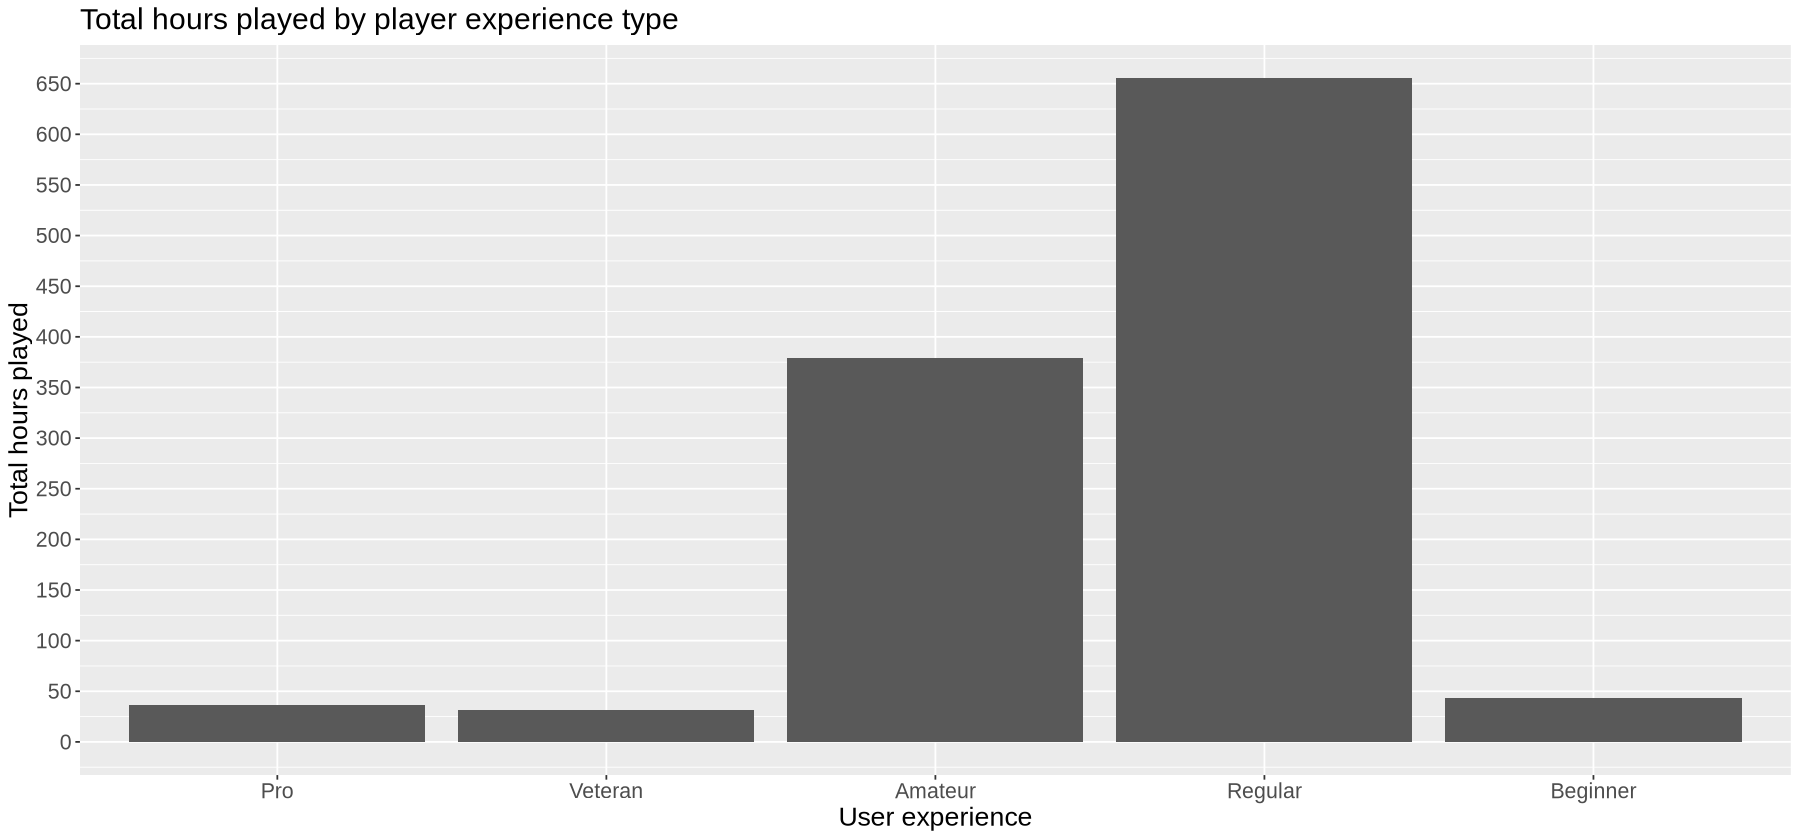

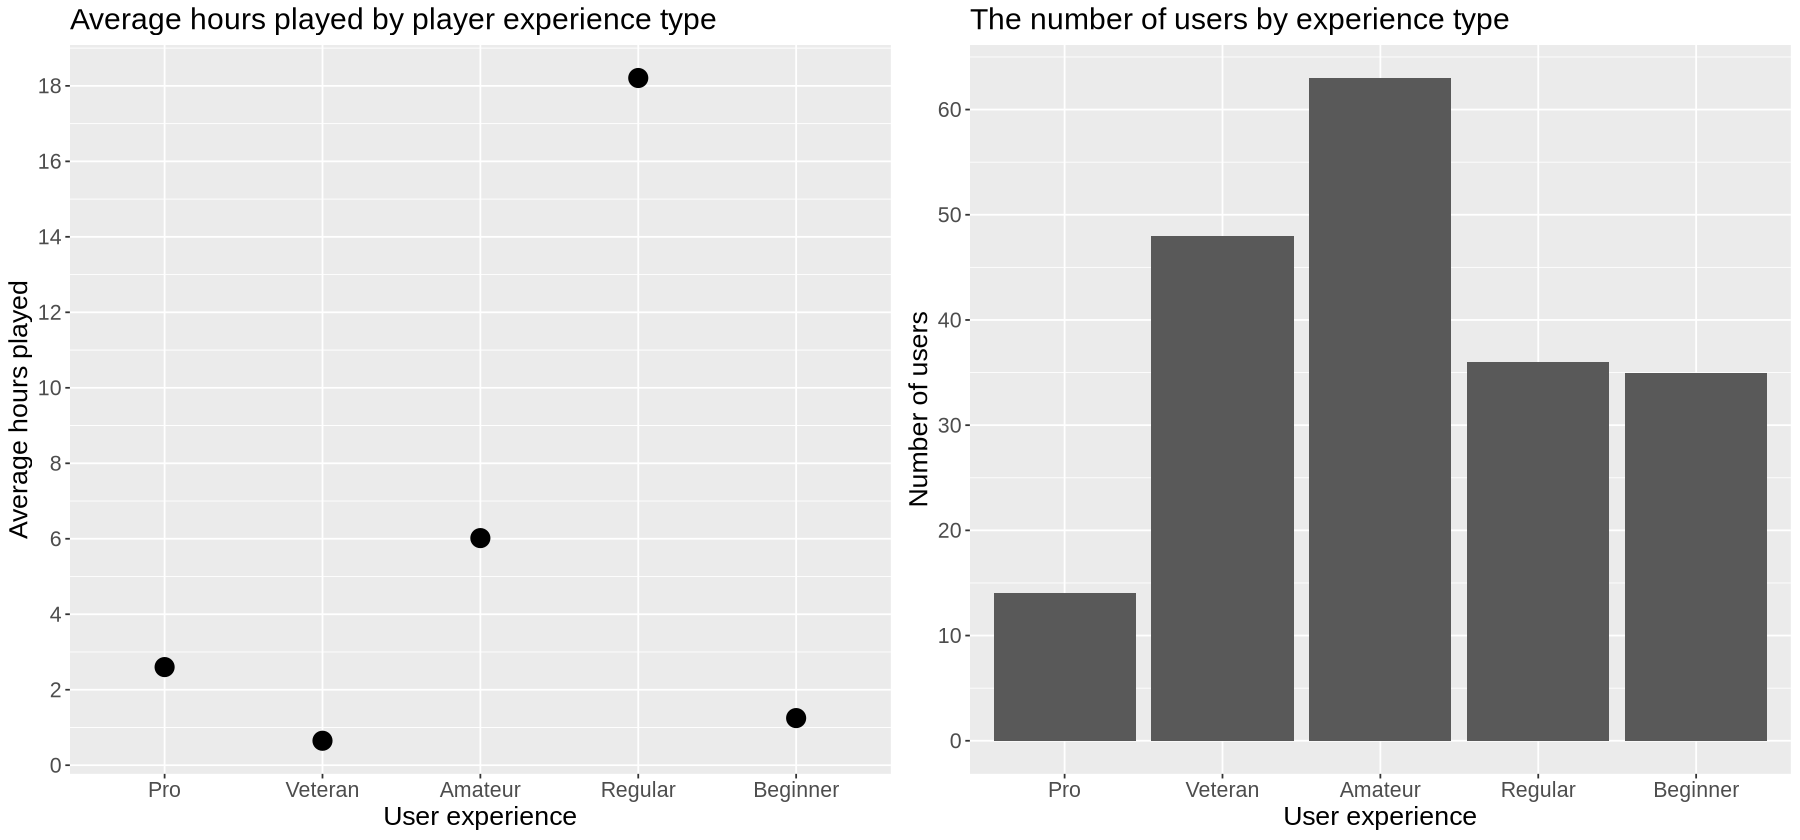

In [12]:
# Creating data frame that is grouped by experience and stores total hours.
players_grouped_total <- players_clean |>
    group_by(experience) |>
    summarize(total_hours = sum(played_hours),
             mean_hours = mean(played_hours),
             count = n()) 

options(repr.plot.width = 15, repr.plot.height = 7) 

# To change color
# scale_fill_brewer(palette = 'Greens')

# Creating a bar plot that shows cumulative hours of all players grouped by experience type.
total_hours_by_experience_plot <- players_grouped_total |>
    ggplot(aes(x = experience, y = total_hours)) +
    geom_bar(stat = "identity" ) +
    labs(x = "User experience", y = "Total hours played") +
    ggtitle("Total hours played by player experience type") +
    scale_y_continuous(breaks = seq(0, 650,by = 50)) +
    theme(text = element_text(size = 16), plot.title = element_text(size = 18))
    

# Creating a bar plot that shows average hours of all players grouped by experience type.
mean_hours_by_experience_plot <- players_grouped_total |>
    ggplot(aes(x = experience, y = mean_hours)) +
    geom_point(size = 5) +
    labs(x = "User experience", y = "Average hours played") +
    ggtitle("Average hours played by player experience type") +
    scale_y_continuous(breaks = seq(0, 20,by = 2)) +
    theme(text = element_text(size = 16), plot.title = element_text(size = 18))

# Creating a bar plot that shows the number of all players grouped by experience type.
count_by_experience_plot <- players_grouped_total |>
    ggplot(aes(x = experience, y = count)) +
    geom_bar(stat = "identity") +
    labs(x = "User experience", y = "Number of users") +
    ggtitle("The number of users by experience type") +
    scale_y_continuous(breaks = seq(0, 70,by = 10)) +
    theme(text = element_text(size = 16), plot.title = element_text(size = 18))

total_hours_by_experience_plot
plot_grid(mean_hours_by_experience_plot, count_by_experience_plot, nrow = 1)


**Insights:** The bar plot depicts cumulative hours played by all users. We can see that the most of the hours played on the game server were by `Regular` experience players, these players played in total around 650 hours. The next group that played the most hours is `Amateur` with around 370 hours of playing. The other three categories played less than 50 hours in total.  
The plot showing mean total hours played grouped by user experience indicates that indeed `Regular` players on average spend much more time playing than any other category. However, we need to keep in mind that the data is unbalanced, as most of the users in our dataset are `Amateurs`, while `Pro` category is underrepresented and it might influence results of the research.

### Exploring correlations between hours played, experience category and other variables

#### Total played hours by experience and subscription status

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


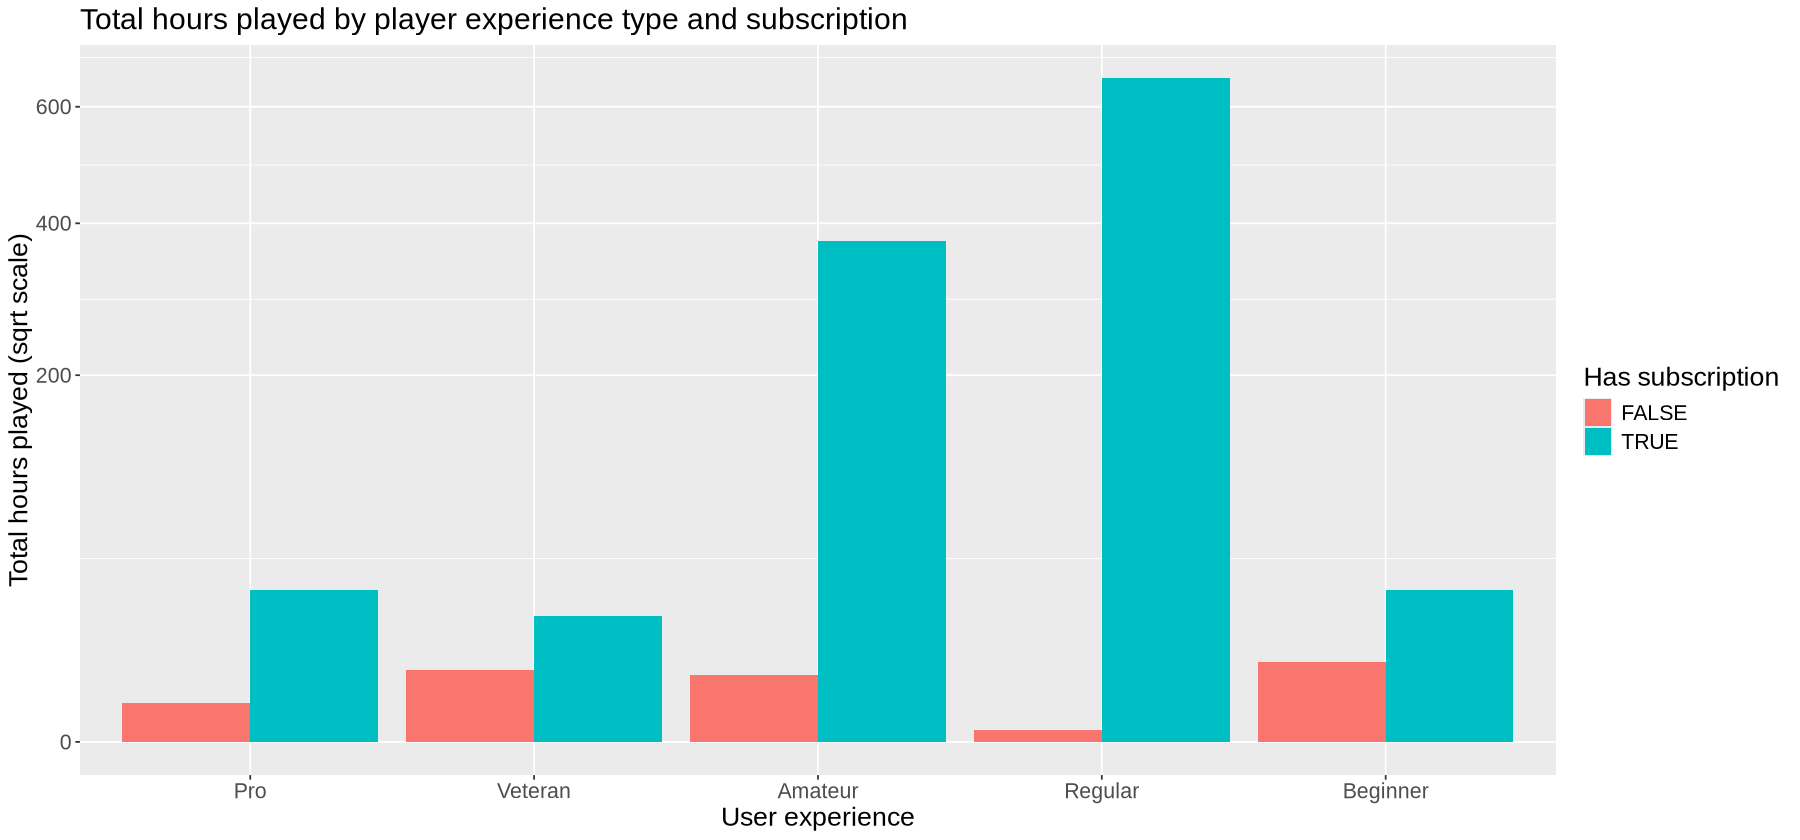

In [13]:
# Grouping players data by both experience and subscription
players_experience_subscription <- players_clean |>
     group_by(experience, is_subscribed) |>
     summarize(total_hours = sum(played_hours))

# Creating a bar plot that shows the number of total hours played by experience and subscription status.
total_hours_by_experience_subscription <- players_experience_subscription |>
    ggplot(aes(x = experience, y = total_hours, fill = is_subscribed)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = "User experience", y = "Total hours played (sqrt scale)", fill = "Has subscription") +
    ggtitle("Total hours played by player experience type and subscription") +
    scale_y_sqrt() +
    theme(text = element_text(size = 16), plot.title = element_text(size = 18))

total_hours_by_experience_subscription

**Insights:** The bar plot shows that the majority of hours played in every experience category came from players who had a subscription. The difference is most visible for `Regular` players, where subscribed users contribute most of the hours. Whereas `Beginners` show the smallest difference between different subscription status, meaning that there might be less influence of the subscription on these type of players and their playtime.

#### Total played hours by experience and gender

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


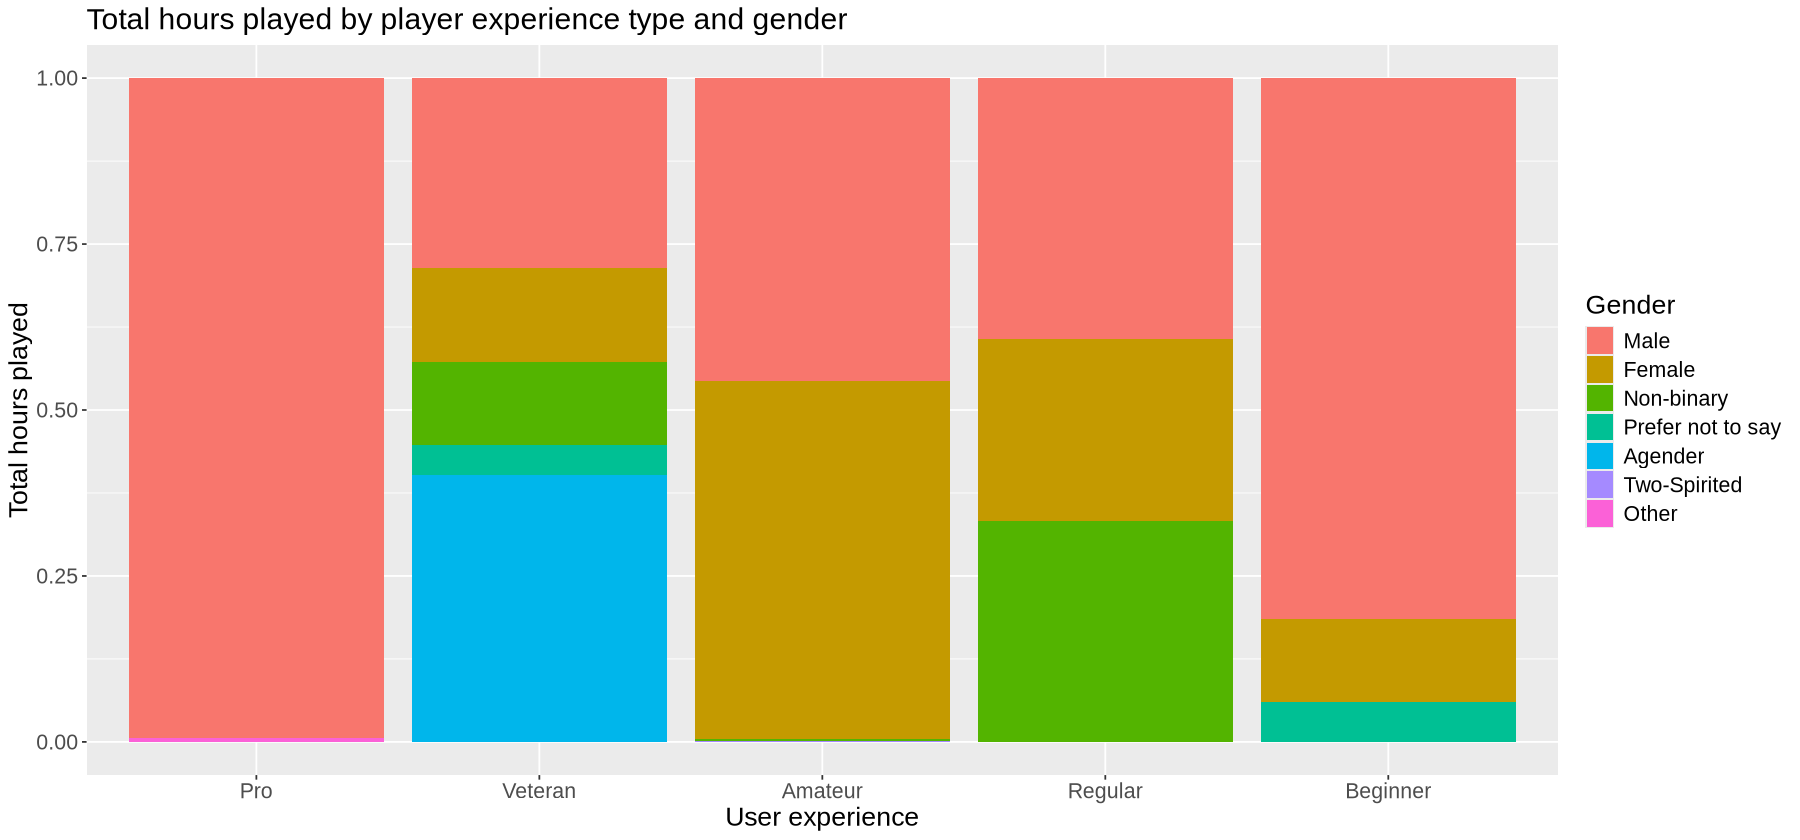

In [14]:
# Grouping players data by both experience and gender
players_experience_gender <- players_clean |>
    group_by(experience, gender) |>
    summarize(total_hours = sum(played_hours))

# Creating a bar plot that shows the proportion of total hours played by experience and gender.
total_hours_by_experience_gender <- players_experience_gender |>
    ggplot(aes(x = experience, y = total_hours, fill = gender)) +
    geom_bar(stat = "identity", position = "fill") +
    labs(x = "User experience", y = "Total hours played", fill = "Gender") +
    ggtitle("Total hours played by player experience type and gender") +
    theme(text = element_text(size = 16), plot.title = element_text(size = 18))

total_hours_by_experience_gender

**Insights:** The stacked bar plot shows the total hours proportions by gender within each experience category. Male players play contribute the most hours in `Pro` and`Beginner` category, whereas female players contribute the most hours in Amateur category. We can see that `Veterans` represent the most gender diversity across all experience levels. Although most of the players are male, the distribution of hours played by gender vary in most of the experience levels. For instance, we only have 2 `Agender` users in dataset, and they contributed almost half of all hours played in `Veteran` group (which consists of 48 players) . This shows that total played time differs within users and shows no consistent patterns by gender.  
*Statistics from `players` dataset summary

#### Total played hours by age and experience 

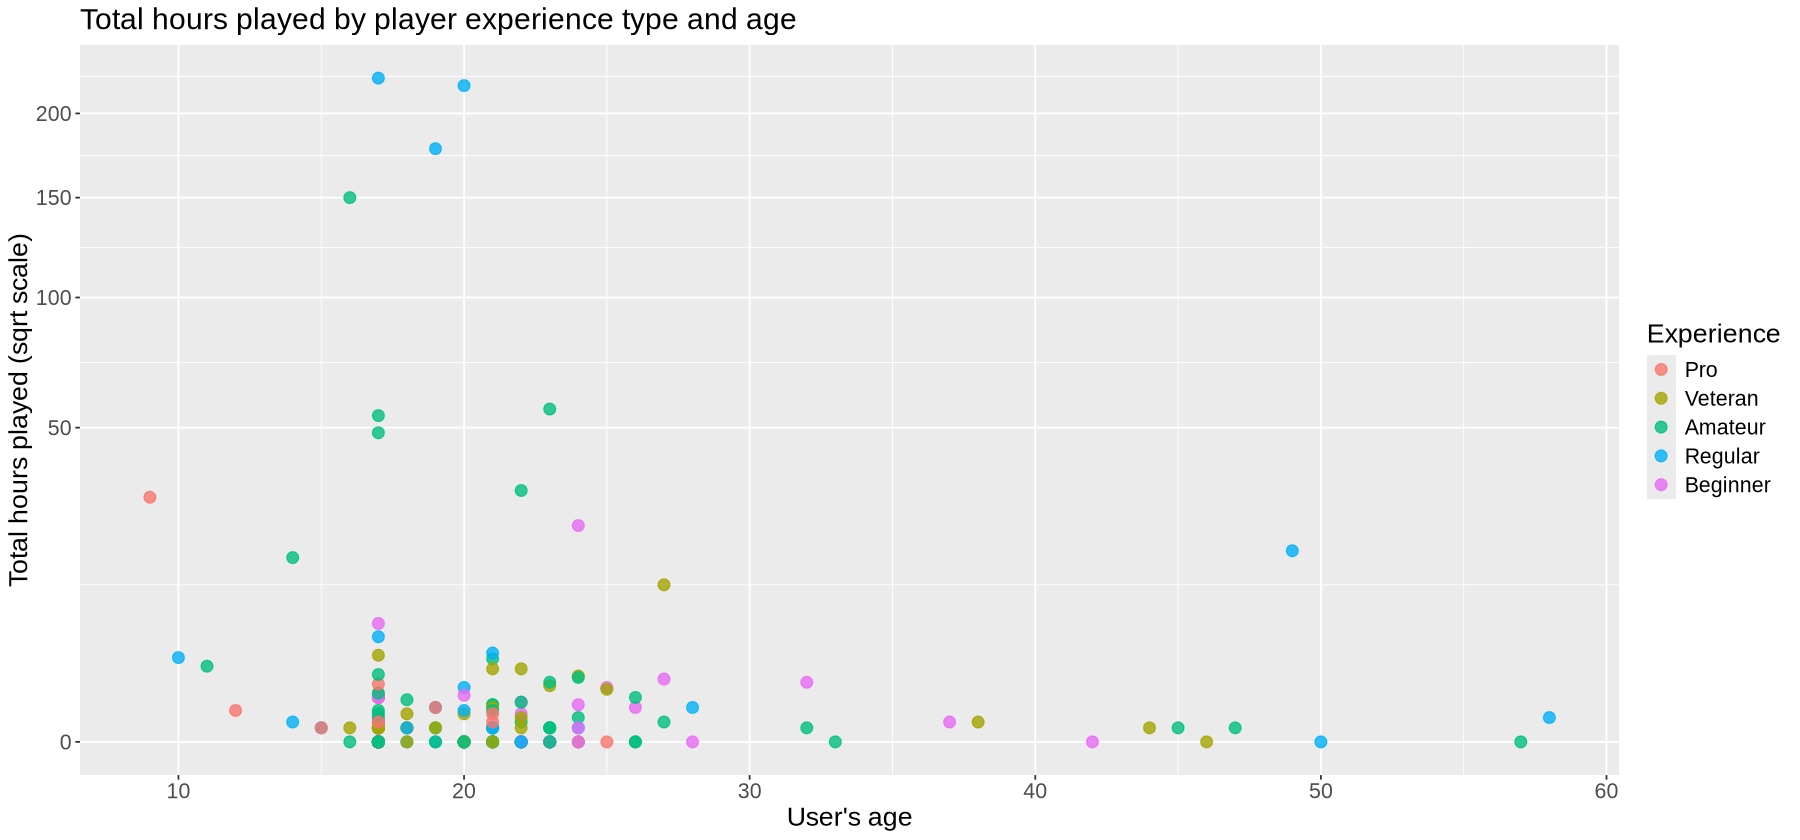

In [15]:
# Creating a bar plot that shows the relationship between user's age and hours played, colored by experience level.
hours_played_age_experience_plot <- players_clean |>
    ggplot(aes(x = age, y = played_hours, color = experience)) +
    geom_point(size = 3, alpha = 0.8) +
    scale_y_sqrt() +
    labs(x = "User's age", y = "Total hours played (sqrt scale)", color = "Experience") +
    ggtitle("Total hours played by player experience type and age") +
    theme(text = element_text(size = 16), plot.title = element_text(size = 18))

hours_played_age_experience_plot

**Insights:** The plot shows the distribution of total hours played by user's age. The majority of active players are within 15 - 30 age group, with only a few players who played more than 50 hours. All players who played more than 150 hours are classified as the `Regular` experience players. The plot shows that there is no specific pattern between experience level, age and hours played. But this visualization shows that `Regular` group contributed the most hours becuase of the three players who played longer than 150 hours. These values are unique and do not represent the behaviour of all users in this category. 

#### Distribution of time played per session

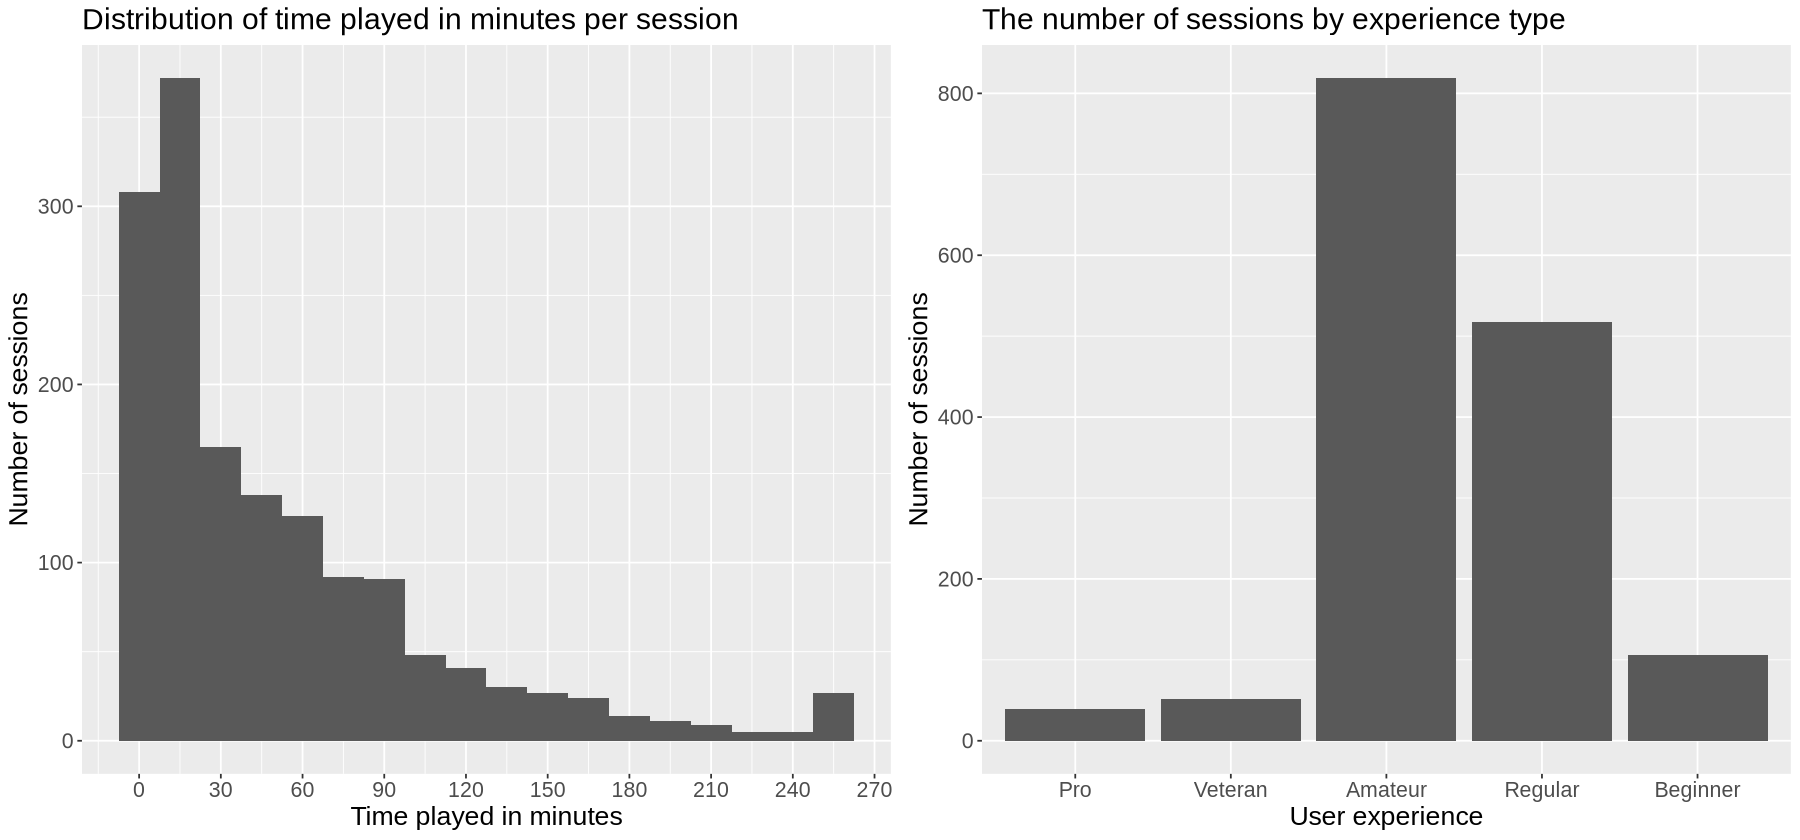

In [16]:
# Creating a histogramm that shows the distribution of playtime per session in minutes.
minute_session_plot <- sessions_joined |>
    ggplot(aes(x = playtime_in_minutes)) +
    geom_histogram(binwidth = 15) +
    scale_x_continuous(breaks = seq(0, 280,by = 30)) +
    labs(x = "Time played in minutes", y = "Number of sessions") +
    ggtitle("Distribution of time played in minutes per session") +
    theme(text = element_text(size = 16), plot.title = element_text(size = 18))

# Creating a plot that shows the number of sessions across different experience categories.
count_by_session_plot <- sessions_joined |>
    ggplot(aes(x = experience)) +
    geom_bar(stat = "count") +
    labs(x = "User experience", y = "Number of sessions") +
    ggtitle("The number of sessions by experience type") +
    theme(text = element_text(size = 16), plot.title = element_text(size = 18))
    
plot_grid(minute_session_plot , count_by_session_plot, nrow = 1)

**Insights:** The histogram shows that most of the users play time per session is less than 100 minutes with a peak at 15 minutes, indicating that user perfer to play casually for a short amount of time. The bar plot depicts that most frequent players are `Amateur` and `Regular` categories, meaning that data is mostly contributed by moderately experienced players.

#### Hours played per session by day and experience

`summarise()` has grouped output by 'week'. You can override using the
`.groups` argument.


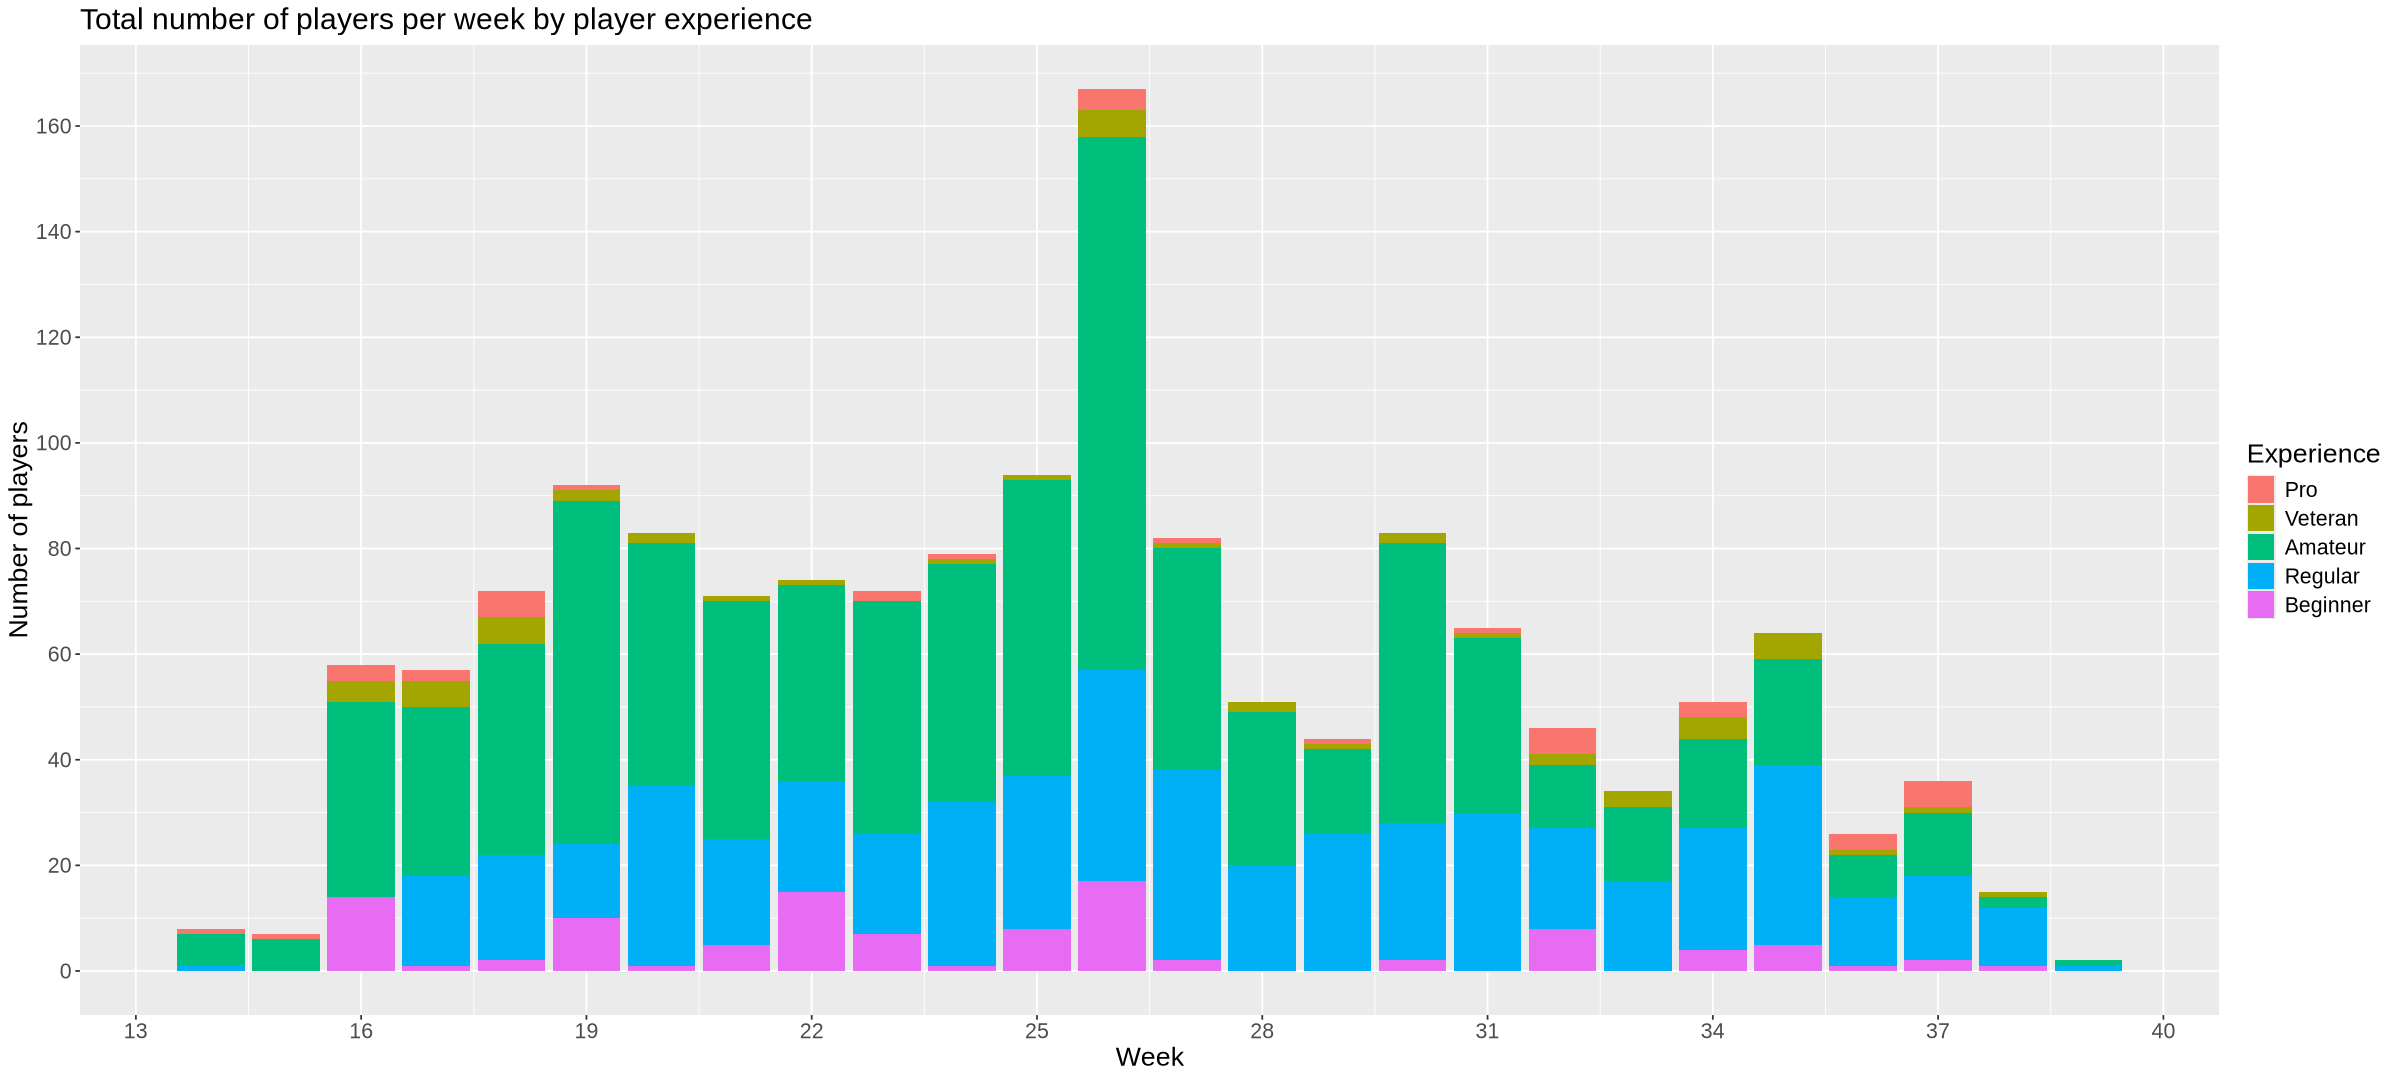

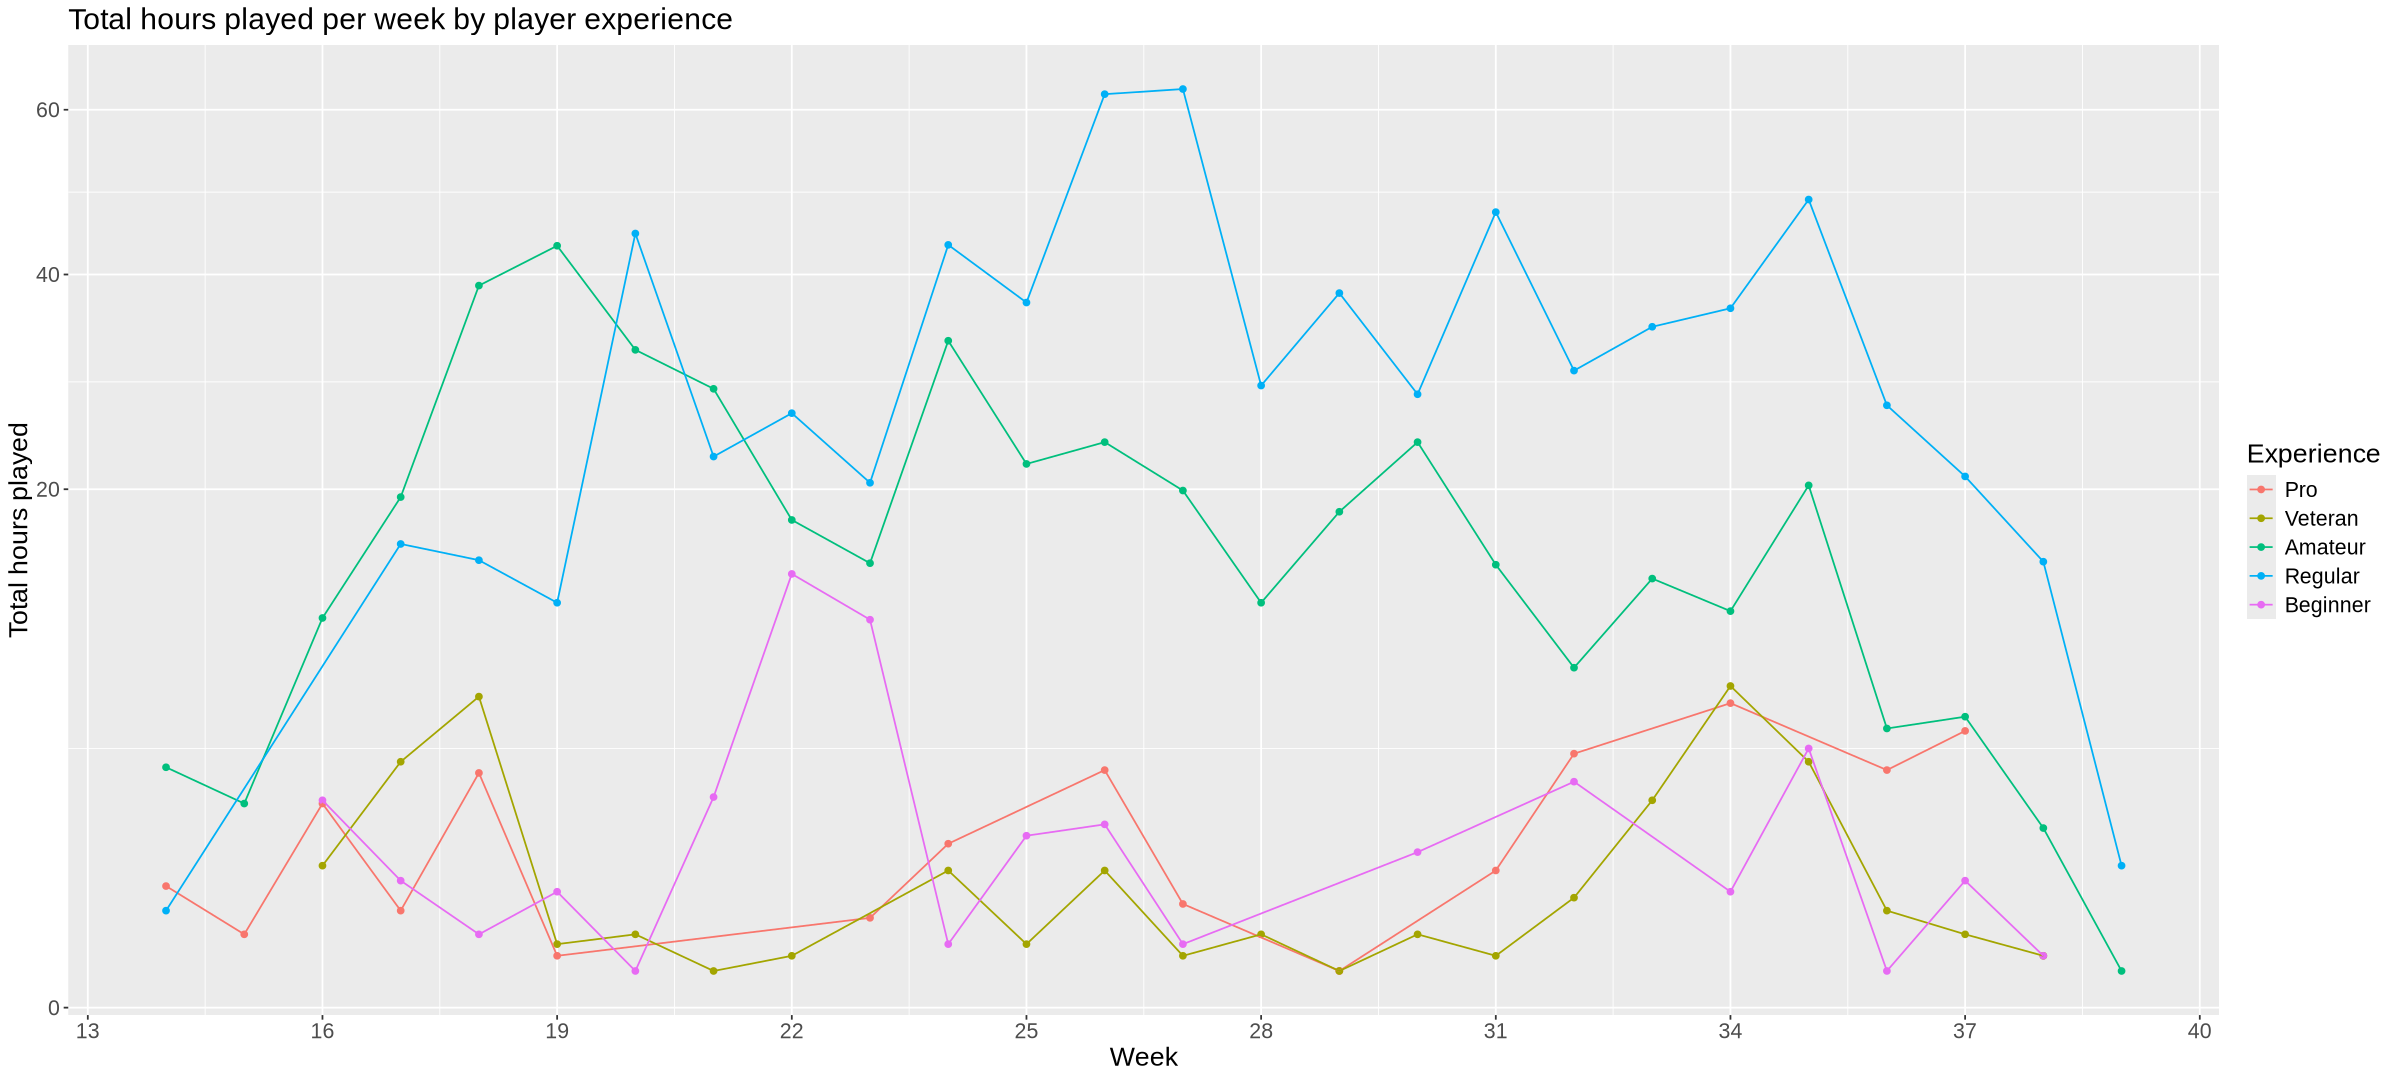

In [17]:
sessions_by_week <- sessions_joined |>
    mutate(week = week(start_date)) |>
    group_by(week, experience) |>
    summarize(number_of_players = n(),
             total_played_hours = sum(playtime_in_hours))

players_by_week_experience_plot <- sessions_by_week |>
    ggplot(aes(x = week, y = number_of_players, fill = experience)) +
    geom_bar(stat = "identity") +
    labs(x = "Week", y = "Number of players", fill = "Experience") +
    ggtitle("Total number of players per week by player experience") +
    scale_y_continuous(breaks = seq(0, 200,by = 20)) +
    scale_x_continuous(breaks = seq(10, 40,by = 3)) +
    theme(text = element_text(size = 16), plot.title = element_text(size = 18))

hours_by_week_experience_plot <- sessions_by_week |>
    ggplot(aes(x = week, y = total_played_hours, color = experience)) +
    geom_point() +
    geom_line() +
    labs(x = "Week", y = "Total hours played", color = "Experience") +
    ggtitle("Total hours played per week by player experience") +
    scale_y_sqrt() +
    scale_x_continuous(breaks = seq(10, 40,by = 3)) +
    theme(text = element_text(size = 16), plot.title = element_text(size = 18))

options(repr.plot.width = 20, repr.plot.height = 9) 
players_by_week_experience_plot
hours_by_week_experience_plot 

**Insights:** These plots display player activity throughout observation period, highlighting the change in the number of active players and hours played for each experience level. We can see that the peak activity was in the week 26-27 with most of the hours contributed by `Regular` players at around 60 hours per day during this period. However, during same week the largest number of players belonged to the `Amateur` category, showing that the time played per session is not consistent across all users.

## Data Analysis

In [19]:
# Splitting the data for training and testing
players_split <- initial_split(players_clean, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [31]:
# Setting K-NN Regression specifications
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# Creating recipe
players_recipe <- recipe(played_hours ~ experience, data = players_training) |>
    step_dummy(all_nominal_predictors()) |> #converting factor to dummy variables
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 1



── Operations 

• Dummy variables from: all_nominal_predictors()

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [32]:
# V-fold to tune the optimal k for K-NN Regression
players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

# Workflow to combine model specification and recipe
players_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_dummy()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [33]:
# Creating a sequence of k values for testing
players_k <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# Tuning workflow so that it tests all k values and resamples cross-validation
players_results <- players_workflow |>
    tune_grid(resamples = players_vfold, grid = players_k) |>
    collect_metrics()

players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,19.448331437,5,7.032264959,Preprocessor1_Model01
1,rsq,standard,0.014962171,5,0.012563181,Preprocessor1_Model01
2,rmse,standard,19.443352526,5,7.033499263,Preprocessor1_Model02
2,rsq,standard,0.012439982,5,0.009458544,Preprocessor1_Model02
3,rmse,standard,19.441399847,5,7.033210885,Preprocessor1_Model03
3,rsq,standard,0.012082674,5,0.010287486,Preprocessor1_Model03
4,rmse,standard,19.442964948,5,7.031908038,Preprocessor1_Model04
4,rsq,standard,0.014863642,5,0.011246395,Preprocessor1_Model04
5,rmse,standard,19.443421144,5,7.032088998,Preprocessor1_Model05


In [34]:
# Finding the minimum RMSPE to find best k
players_min <- players_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n = 1)

players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,rmse,standard,19.4414,5,7.033211,Preprocessor1_Model03


In [36]:
# Find RMSPE to test model on unseen data
k_min <- players_min |>
    pull(neighbors)

# Setting specifications using k = 3
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("regression")

# Fitting the workflow to the training dataset
players_best_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_best_spec) |>
    fit(data = players_training)

# Testing dataset on unseen data
players_summary <- players_best_fit |>
    predict(players_testing) |>
    bind_cols(players_testing) |>
    metrics(truth = played_hours, estimate = .pred)

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,39.96595273
rsq,standard,0.01344244
mae,standard,8.98133333


**Insights:** The RMPSE from our testing data is significantly higher than the cross-validation RMPSE of our best model with about a 20 hour difference. This means that K-NN regression using `experience` is not predicting `played_hours` well on unseen data.

In [40]:
set.seed(2019)
options(repr.plot.width = 7, repr.plot.heigh = 7)

# Predicting on training dataset
players_preds <- players_best_fit |>
    predict(players_training) |>
    bind_cols(players_training)

# players_plot <- players_preds |>
#     ggplot(aes(x = experience, y = played_hours)) +
#     geom_point(alpha = 0.4) +
#     labs(x = "Experience Level", y = "Hours Played") +
#     geom_line(data = players_preds, aes(x = experience, y = .pred), color = "blue") +
#     ggtitle("Hours Played vs Experience Level") +
#     theme(text = element_text(size = 20))

# players_plot